In [1]:
import json
from collections import Counter, defaultdict
import gc

import numpy as np
import pandas as pd
import glob
import time
from tqdm import tqdm

from sklearn import model_selection, metrics
import matplotlib.pyplot as plt
import seaborn as sn

import lightgbm as lgb
import feather

#import riiideducation

In [2]:
question = pd.read_csv("/home/pocket/input/questions.csv")
question.head(2)

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81


<AxesSubplot:>

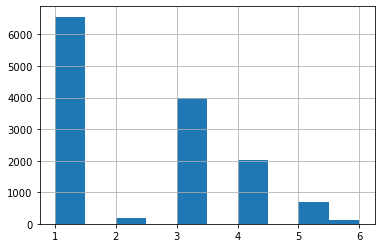

In [3]:
question["tags"].astype(str).apply(lambda x: len(x.split())).hist()

In [40]:
train = pd.read_feather("./train.feather")

In [24]:
print(train.columns)

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation'],
      dtype='object')


In [6]:
print("hi")

hi


In [98]:
train_now = pd.read_feather("./train_sorted_full2.feather")

In [12]:
train_now["u_seq_len"] = train_now.groupby("user_id")["user_id"].transform("count")

In [36]:
train_now_val = train_now.iloc[-25*100*1000:]
train_now_train = train_now.iloc[:-25*100*1000]

In [37]:
val_set = set(train_now_val["user_id"])
tr_set = set(train_now_train["user_id"])

In [38]:
print(len(tr_set))
print(len(val_set))
print(len(val_set - tr_set))

378837
24855
14819


In [79]:
14819 / (24855) * 100

59.621806477569905

In [39]:
print(train_now["u_seq_len"].mean())
print(train_now_train["u_seq_len"].mean())
print(train_now_val["u_seq_len"].mean())

2430.289205393498
2453.094638899827
1529.6539968


In [30]:
train["u_seq_len"] = train.groupby("user_id")["user_id"].transform("count")

In [25]:
train = train.sort_values(by="timestamp")

In [32]:
train_val = train.iloc[-5*1000*1000:]
train_train = train.iloc[:-5*1000*1000]

In [34]:
val_set = set(train_val["user_id"])
tr_set = set(train_train["user_id"])

In [35]:
print(len(tr_set))
print(len(val_set))
print(len(val_set - tr_set))

393656
13914
0


In [33]:
print(train["u_seq_len"].mean())
print(train_train["u_seq_len"].mean())
print(train_val["u_seq_len"].mean())

2430.289205393498
2335.5586668556853
4253.4794402


{1}

In [48]:
train["u_seq_len"] = train.groupby("user_id")["user_id"].transform("count")
train_val = train.iloc[-5*1000*1000:]
train_train = train.iloc[:-5*1000*1000]
val_set = set(train_val["user_id"])
tr_set = set(train_train["user_id"])
print(len(tr_set))
print(len(val_set))
print(len(val_set - tr_set))
print(train["u_seq_len"].mean())
print(train_train["u_seq_len"].mean())
print(train_val["u_seq_len"].mean())

371095
26792
22561
2430.289205393498
2454.1696050264068
1970.6854484


In [80]:
22561 / (26792) * 100

84.20797252911318

In [76]:
# tito-san cv

train = pd.read_feather("./train.feather")
import random
random.seed(3)

max_timestamp_u = train[['user_id','timestamp']].groupby(['user_id']).agg(['max']).reset_index()
max_timestamp_u.columns = ['user_id', 'max_time_stamp']
MAX_TIME_STAMP = max_timestamp_u.max_time_stamp.max()
MAX_TIME_STAMP = int(MAX_TIME_STAMP * 2)
#(MAX_TIME_STAMP for all users) - (max_time_stamp for each user) is used for this interval.

def rand_time(max_time_stamp):
    interval = MAX_TIME_STAMP - max_time_stamp
    rand_time_stamp = random.randint(0,interval)
    return rand_time_stamp

max_timestamp_u['rand_time_stamp'] = max_timestamp_u.max_time_stamp.apply(rand_time)
train = train.merge(max_timestamp_u, on='user_id', how='left')
train['virtual_time_stamp'] = train.timestamp + train['rand_time_stamp']

# kaggle_env = True
# if kaggle_env:
#     # Full dataframe can not be sorted on kaggle kernel due to lack of memory.
#     train = train[:1*1000*1000]
train = train.sort_values(['virtual_time_stamp', 'row_id']).reset_index(drop=True)



In [77]:
train["u_seq_len"] = train.groupby("user_id")["user_id"].transform("count")
train_val = train.iloc[-5*1000*1000:]
train_train = train.iloc[:-5*1000*1000]
val_set = set(train_val["user_id"])
tr_set = set(train_train["user_id"])
print(len(tr_set))
print(len(val_set))
print(len(val_set - tr_set))
print(train["u_seq_len"].mean())
print(train_train["u_seq_len"].mean())
print(train_val["u_seq_len"].mean())

368864
33173
24792
2430.289205393498
2462.5563295988627
1809.2739904


In [81]:
24792 / 33173 * 100

74.7354776474844

In [121]:


u_cnt = Counter()
u_ac_cnt = Counter()
u_ac_sum, u_qm_sum = Counter(), Counter()

def update_ac_values(prev_rows, prev_acs, prev_uas):
    #for i, row in enumerate(prev_df.values):
    for i, row in enumerate(prev_rows):
        update_ac_value(row, prev_acs[i], prev_uas[i])
    
def update_ac_value(row, prev_ac, prev_ua):
    uid = int(row[2])
    cid = int(row[3])
    ucid = (uid, cid)
    
    u_ac_cnt[uid] += 1
    u_ac_sum[uid] += prev_ac

def make_row(row, data_list, is_train=True):
    ts = int(row[1])
    uid = int(row[2])
    cid = int(row[3])
    tcid = int(row[5])
    if is_train:
        et = row[8]
        pqhe = row[9]
    else:
        et = row[6]
        pqhe = row[7]
    ucid = (uid, cid)
    utcid = (uid, tcid)
    contents = contents_dict[cid]
    
    output = {}
    if is_train:
        output["ac"] = row[7]
    output["et"] = et
    content_col = [
        "q_ac_mean", "q_ac_cnt", "q_et_mean", "q_et_cnt", "q_et_std", "b_ac_mean", "b_ac_cnt",
    ]
    for c in content_col:
        output[c] = contents[c]
    
    u_cnt[uid] += 1
    u_qm_sum[uid] += contents["q_ac_mean"]
    output["u_cnt"] = u_cnt[uid]
    output["u_ac_cnt"] = u_ac_cnt[uid]
    output["u_ac_mean"] = (u_ac_sum[uid] / u_ac_cnt[uid]) if u_ac_cnt[uid] != 0 else np.nan
    output["u_qm_mean"] = u_qm_sum[uid] / u_cnt[uid]
    
    data_list.append(output)
    return data_list



In [51]:
content_train = train[train["answered_correctly"] != -1].copy()


q_col = ["question_id", "bundle_id"]
content_train = pd.merge(
    content_train, question[q_col], left_on="content_id", right_on="question_id", how="left"
)

# contents features
# there are no new contents in the test, so we use part of the train as the pseudo-training set
temp = content_train.groupby("content_id")["answered_correctly"].agg(["mean", "count"])
temp.columns = ["q_ac_mean", "q_ac_cnt"]
temp2 = content_train.groupby("content_id")["prior_question_elapsed_time"].agg(["mean", "count", "std"])
temp2.columns = ["q_et_mean", "q_et_cnt", "q_et_std"]
# temp3 = content_train.groupby("content_id")["timestamp_diff"].agg(["mean", "std", "min", "max", "skew"])
# temp3.columns = ["q_td_mean", "q_td_std", "q_td_min", "q_td_max", "q_td_skew"]
temp4 = content_train.groupby("bundle_id")["answered_correctly"].agg(["mean", "count"])
temp4.columns = ["b_ac_mean", "b_ac_cnt"]
q_col = ["question_id", "bundle_id"]
#q_col += [str(i) for i in range(188)]
contents = pd.merge(question[q_col], temp, left_on="question_id", right_on="content_id", how="left")
contents = pd.merge(contents, temp2, left_on="question_id", right_on="content_id", how="left")
#contents = pd.merge(contents, temp3, left_on="question_id", right_on="content_id", how="left")
contents = pd.merge(contents, temp4, on="bundle_id", how="left")
print(contents.head(2))
print(contents.shape)
merge_col = [
    "question_id", "q_ac_mean", "q_ac_cnt", "q_et_mean",
    "q_et_cnt", "q_et_std", "b_ac_mean", "b_ac_cnt"
]
contents = contents[merge_col]
contents = contents.set_index("question_id")
contents_dict = contents.to_dict("index")
print(len(contents_dict))

   question_id  bundle_id  q_ac_mean  q_ac_cnt     q_et_mean  q_et_cnt  \
0            0          0   0.907721      6903  21875.328125      6901   
1            1          1   0.890646      7398  22091.626953      7398   

       q_et_std  b_ac_mean  b_ac_cnt  
0  10519.116289   0.907721      6903  
1  10867.885630   0.890646      7398  
(13523, 9)
13523


In [126]:
class SingleLgb:
    def __init__(self, seed=99, dry_run=False):
        self.train_param = self.get_param()
        if dry_run:
            self.num_rounds = 100
        else:
            self.num_rounds = 1000

    def do_train_direct(self, x_train, x_test, y_train, y_test):
        lgb_train = lgb.Dataset(x_train, y_train)
        lgb_eval = lgb.Dataset(x_test, y_test)

        # print('Start training...')
        model = lgb.train(self.train_param,
                          lgb_train,
                          valid_sets=[lgb_eval],
                          verbose_eval=100,
                          num_boost_round=self.num_rounds,
                          early_stopping_rounds=100,
                          #categorical_feature=[]
                         )
        # print('End training...')
        return model

    @staticmethod
    def show_feature_importance(model, filename=None):
        fi = pd.DataFrame({
            "name": model.feature_name(),
            "importance_split": model.feature_importance(importance_type="split").astype(int),
            "importance_gain": model.feature_importance(importance_type="gain").astype(int),
        })
        fi = fi.sort_values(by="importance_gain", ascending=False)
        print(fi)
        #with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
            #print(df)

    @staticmethod
    def get_param():
        return {
            'num_leaves': 31,
            'min_data_in_leaf': 50,
            'objective': 'binary',
            #'metric': 'auc',
            'metric': 'binary_logloss',
            'max_depth': -1,
            'learning_rate': 0.05,
            "boosting": "gbdt",
            "feature_fraction": 0.9,
            "verbosity": -1,
            "random_state": 81,
        }
    
class SingleTrainer:
    def __init__(self, pred_col, dry_run=False):
        self.pred_col = pred_col
        self.target_col = "ac"
        self.dry_run = dry_run
        self.val_size = 25*100*1000

    def train_model(self, df):
        X = df[self.pred_col]
        y = df[self.target_col]
        
        models, scores = list(), list()
        for fold in range(4):
            print("---------")
            print("fold=", fold)
            f, c = fold, self.val_size
            val_s, val_e = -c-f*c, len(df)-f*c
            train_idx = -c-f*c
            X_train, X_val = X.iloc[:train_idx], X.iloc[val_s:val_e]
            y_train, y_val = y.iloc[:train_idx], y.iloc[val_s:val_e]
            print(X_train.shape, X_val.shape)
            
            lgbm = SingleLgb(seed=99, dry_run=self.dry_run)
            model = lgbm.do_train_direct(X_train, X_val, y_train, y_val)
            score = model.best_score["valid_0"]["binary_logloss"]
            pred = model.predict(X_val)
            score = metrics.roc_auc_score(y_val, pred)
            print("AUC=", score)
            if fold == 0:
                lgbm.show_feature_importance(model)
            models.append(model)
            scores.append(score)
            break
        return models, np.mean(scores)

In [101]:
train_now = train_now[train_now["answered_correctly"] != -1]

In [104]:
train_data_list = list()
utcid_set = set()
prev_rows, prev_acs, prev_uas = list(), list(), list()

not_updated_idx = 0
for i, row in enumerate(tqdm(train_now.values)):
    uid = row[2]
    tcid = row[5]
    utcid = (uid, tcid)
    if utcid not in utcid_set:
        if len(prev_rows) > 0:
            #prev_df2 = train.iloc[not_updated_idx:i] iloc too slow lol
            update_ac_values(prev_rows, prev_acs, prev_uas)
            prev_rows.clear()
            prev_acs.clear()
            prev_uas.clear()
            utcid_set.clear()
            not_updated_idx = i
    prev_rows.append(row)
    prev_acs.append(row[7])
    prev_uas.append(row[6])
    utcid_set.add(utcid)
        
    make_row(row, train_data_list, True)
        
    
df = pd.DataFrame(train_data_list)
print(df.head(2))
#print(df.info())

100%|██████████| 99271300/99271300 [20:25<00:00, 80991.19it/s]  


    ac       et  q_ac_mean  q_ac_cnt     q_et_mean  q_et_cnt      q_et_std  \
0  1.0      NaN   0.966869     19619  23471.402344      5406  16817.431721   
1  1.0  16000.0   0.954815     21733  19462.746094     21732  10070.528940   

   b_ac_mean  b_ac_cnt  u_cnt  u_ac_cnt  u_ac_mean  u_qm_mean  
0   0.966869     19619      1         0        NaN   0.966869  
1   0.954815     21733      2         1        1.0   0.960842  


In [122]:
train_val = train_now.iloc[-25*100*1000:].copy()

In [123]:
train_data_list = list()
utcid_set = set()
prev_rows, prev_acs, prev_uas = list(), list(), list()

not_updated_idx = 0
for i, row in enumerate(tqdm(train_val.values)):
    uid = row[2]
    tcid = row[5]
    utcid = (uid, tcid)
    if utcid not in utcid_set:
        if len(prev_rows) > 0:
            #prev_df2 = train.iloc[not_updated_idx:i] iloc too slow lol
            update_ac_values(prev_rows, prev_acs, prev_uas)
            prev_rows.clear()
            prev_acs.clear()
            prev_uas.clear()
            utcid_set.clear()
            not_updated_idx = i
    prev_rows.append(row)
    prev_acs.append(row[7])
    prev_uas.append(row[6])
    utcid_set.add(utcid)
        
    make_row(row, train_data_list, True)
        
    
df_val = pd.DataFrame(train_data_list)
print(df_val.head(2))
#print(df.info())

100%|██████████| 2500000/2500000 [00:28<00:00, 87138.86it/s]


    ac       et  q_ac_mean  q_ac_cnt     q_et_mean  q_et_cnt      q_et_std  \
0  1.0  18000.0   0.524963      7351  18318.365234      7351   9148.979822   
1  1.0  19000.0   0.538570     27042  25251.115234     26965  22010.051535   

   b_ac_mean  b_ac_cnt  u_cnt  u_ac_cnt  u_ac_mean  u_qm_mean  
0   0.524963      7351      1         0        NaN   0.524963  
1   0.538570     27042      1         0        NaN   0.538570  


In [105]:
# %%timeit
# df = pd.DataFrame(data_list)
# 24.7 s ± 205 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [69]:
df.describe()

,ac,et,q_ac_mean,q_ac_cnt,q_et_mean,q_et_cnt,q_et_std,b_ac_mean,b_ac_cnt,u_cnt,u_ac_cnt,u_ac_mean,u_qm_mean
count,9.927130e+07,9.887879e+07,9.927130e+07,9.927130e+07,9.927130e+07,9.927130e+07,9.927129e+07,9.927130e+07,9.927130e+07,9.927130e+07,9.927130e+07,9.887484e+07,9.927130e+07
mean,6.572355e-01,2.542381e+04,6.572355e-01,2.521723e+04,2.541681e+04,2.491416e+04,1.802090e+04,6.572355e-01,4.546867e+04,1.196893e+03,1.195480e+03,6.433691e-01,6.515675e-01
std,4.746335e-01,1.994815e+04,1.742359e-01,3.820202e+04,6.479250e+03,3.761324e+04,5.571927e+03,1.532885e-01,9.440778e+04,1.833863e+03,1.833807e+03,1.295386e-01,7.147249e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.333000e+03,1.000000e+00,3.204019e+03,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.006072e-01
25%,0.000000e+00,1.600000e+04,5.471624e-01,6.211000e+03,2.269374e+04,6.194000e+03,1.243090e+04,5.625434e-01,9.777000e+03,1.240000e+02,1.230000e+02,5.833333e-01,6.195605e-01
50%,1.000000e+00,2.100000e+04,6.763632e-01,1.240600e+04,2.486438e+04,1.236700e+04,2.018806e+04,6.752029e-01,1.912400e+04,4.840000e+02,4.830000e+02,6.645570e-01,6.631833e-01
75%,1.000000e+00,2.966600e+04,7.885033e-01,2.466000e+04,2.567838e+04,2.466000e+04,2.201005e+04,7.655832e-01,3.810500e+04,1.446000e+03,1.444000e+03,7.258065e-01,6.977971e-01
max,1.000000e+00,3.000000e+05,1.000000e+00,2.136050e+05,5.918858e+04,2.135260e+05,5.310611e+04,1.000000e+00,6.411980e+05,1.760900e+04,1.760800e+04,1.000000e+00,9.893495e-01


In [106]:
df.columns

Index(['ac', 'et', 'q_ac_mean', 'q_ac_cnt', 'q_et_mean', 'q_et_cnt',
       'q_et_std', 'b_ac_mean', 'b_ac_cnt', 'u_cnt', 'u_ac_cnt', 'u_ac_mean',
       'u_qm_mean'],
      dtype='object')

In [124]:


pred_col = [
    'q_ac_mean', 'q_ac_cnt', 'q_et_mean', 'q_et_cnt', 'q_et_std', 'b_ac_mean', 'b_ac_cnt',
    'u_cnt', 'u_qm_mean', 'u_ac_mean', 'et'
]

In [125]:
temp_train = df.iloc[:-25*100*1000]
temp_val = df_val
temp_df = pd.concat([temp_train, temp_val], axis=0)
print(temp_df.shape)

(99271300, 13)


In [109]:
temp_df = df.copy()

In [127]:
#temp_df = df[1*1000*1000:].copy()

trainer = SingleTrainer(pred_col, dry_run=False)
models, score = trainer.train_model(temp_df)

---------
fold= 0
(96771300, 11) (2500000, 11)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.550202
[200]	valid_0's binary_logloss: 0.548802
[300]	valid_0's binary_logloss: 0.548385
[400]	valid_0's binary_logloss: 0.54811
[500]	valid_0's binary_logloss: 0.547901
[600]	valid_0's binary_logloss: 0.547742
[700]	valid_0's binary_logloss: 0.547592
[800]	valid_0's binary_logloss: 0.547475
[900]	valid_0's binary_logloss: 0.547366
[1000]	valid_0's binary_logloss: 0.547269
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.547269
AUC= 0.7635267259624468
         name  importance_split  importance_gain
0   q_ac_mean              3990        129523915
9   u_ac_mean              3812         39060063
5   b_ac_mean              1947         12693169
8   u_qm_mean              2910         11192396
10         et              2366          2943730
7       u_cnt              2977          2666587
2   q_et_mean           

In [128]:
publicLB = temp_df.iloc[-25*100*1000:-20*100*1000]
privateLB = temp_df.iloc[-20*100*1000:]

In [130]:
public_pred = models[0].predict(publicLB[pred_col])
private_pred = models[0].predict(privateLB[pred_col])

In [132]:
public_score = metrics.roc_auc_score(publicLB["ac"], public_pred)
private_score = metrics.roc_auc_score(privateLB["ac"], private_pred)

In [133]:
public_score, private_score

(0.7577862749486305, 0.7649490305836172)

In [28]:
# max-timestamp * 5
# with cached feats = 762
# cleared cached feats = 0.7615

# *2
# cached = 0.76199
# not cached = 0.7614

# *1
# cached = 0.7645
# not cached = 0.7635

In [ ]:
def make_pred_df(df):
    pred_data_list = list()
    for i, row in enumerate(df.values):
        make_row(row, pred_data_list, False)
    pred_df = pd.DataFrame(pred_data_list)
    return pred_df

In [ ]:
env = riiideducation.make_env()
is_train = False
init_values()

In [ ]:
prev_df = None
for (test_df, sample_prediction_df) in env.iter_test():
    #show_col = ["row_id", "user_id", "content_type_id", "prior_group_answers_correct", "prior_group_responses"]
    #print(test_df.head(2))
    #print(sample_prediction_df.head(2))
    prev_ac = eval(test_df.iloc[0]["prior_group_answers_correct"])
    prev_ua = eval(test_df.iloc[0]["prior_group_responses"])
    use_df = test_df[test_df['content_type_id'] == 0]
    #print("--------------------")
    
    if len(prev_ac) > 0:
        update_ac_values(prev_df.values, prev_ac, prev_ua)
    pred_df = make_pred_df(use_df)
    #print(pred_df.head(2))
    pred = models[0].predict(pred_df[pred_col])
    prev_df = use_df
    
    sub_df = use_df[["row_id"]].copy()
    sub_df["answered_correctly"] = pred
    env.predict(sub_df)
    #test_df['answered_correctly'] = 0.5
    #env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])


#print(pred_df.columns)
